# Generalization by Covariate Shift Minimization Principle.
Reproduction code of Algorithm 1 in the paper

## Import required functions and load data
Note:
- Before running this code, you need to run Generate_FJS_data.ipynb to generate JFS data.

In [13]:
import logging
import torchvision.transforms as transforms
import torchvision
import torch
from utils import data_from_mnist, LeNet5, test_classifier, CosineLRSchedule, AutoEncoder
from utils import Model as NF
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

logging.basicConfig(level = logging.INFO)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ---------------------------------------------------------load data
num_classes = 10
batch_size = 256
transform = transforms.Compose([transforms.ToTensor(),])
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)
target_path = r"data/MNIST/generate/Mnist-target-images"
target_label_path = r"data/MNIST/generate/Mnist-target-labels"
target_images, target_labels = data_from_mnist(target_path,target_label_path)
target_images = torch.from_numpy(target_images.copy()).unsqueeze(1).float()
target_images = target_images/255.0
target_labels = torch.from_numpy(target_labels.copy()).long()
targetset = torch.utils.data.TensorDataset(target_images,target_labels)
target_data_loader = torch.utils.data.DataLoader(targetset, batch_size=batch_size, shuffle=True, drop_last=True)
logging.info("Load data successfully!")

INFO:root:Load data successfully!


## Train Classifier on Source Domain

In [3]:
# ------------------------------------------------------Train Classifier on Source Domain
classifier = LeNet5().to(device)
learning_rate = 0.01
num_epochs = 150
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)
Source_classifier_on_test_accs = []
Source_classifier_on_target_accs = []
for epoch in range(num_epochs):
    classifier = classifier.train()
    for images,labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = classifier(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
    test_acc, target_acc, _, _ = test_classifier(classifier,test_data_loader,target_data_loader)
    logging.info(f"Train classifier -> Epoch: {epoch}, loss: {loss:.6f}, test_acc: {test_acc:.4f}, target_acc: {target_acc:.4f}")
    Source_classifier_on_test_accs.append(test_acc)
    Source_classifier_on_target_accs.append(target_acc)
logging.info("Train classifier on source domain successfully!")

INFO:root:Train classifier -> Epoch: 0, loss: 2.258033, test_acc: 0.3155, target_acc: 0.1804
INFO:root:Train classifier -> Epoch: 1, loss: 2.067820, test_acc: 0.5149, target_acc: 0.1054
INFO:root:Train classifier -> Epoch: 2, loss: 1.410469, test_acc: 0.6333, target_acc: 0.1351
INFO:root:Train classifier -> Epoch: 3, loss: 1.018315, test_acc: 0.7493, target_acc: 0.2026
INFO:root:Train classifier -> Epoch: 4, loss: 0.793410, test_acc: 0.8097, target_acc: 0.2249
INFO:root:Train classifier -> Epoch: 5, loss: 0.653266, test_acc: 0.8408, target_acc: 0.2325
INFO:root:Train classifier -> Epoch: 6, loss: 0.657191, test_acc: 0.8594, target_acc: 0.2403
INFO:root:Train classifier -> Epoch: 7, loss: 0.583414, test_acc: 0.8742, target_acc: 0.2563
INFO:root:Train classifier -> Epoch: 8, loss: 0.440864, test_acc: 0.8842, target_acc: 0.2716
INFO:root:Train classifier -> Epoch: 9, loss: 0.440908, test_acc: 0.8900, target_acc: 0.2764
INFO:root:Train classifier -> Epoch: 10, loss: 0.353915, test_acc: 0.8

## Get Normalizition Flow on Source Domain

In [4]:
num_classes = 10
img_size = 28
channel_size = 1
patch_size = 2
channels = 128
blocks = 4
layers_per_block = 4
noise_std = 0.1
batch_size = 256
lr = 2e-3
num_epochs = 100
sample_freq = 10
model_nf1 = NF(in_channels=channel_size, img_size=img_size, patch_size=patch_size, channels=channels, num_blocks=blocks, layers_per_block=layers_per_block).to(device)
optimizer = torch.optim.AdamW(model_nf1.parameters(), betas=(0.9, 0.95), lr=lr, weight_decay=1e-4)
lr_schedule = CosineLRSchedule(optimizer, len(test_data_loader), num_epochs * len(test_data_loader), 1e-6, lr)
for epoch in range(num_epochs):
    losses = 0
    for x, y in test_data_loader:
        x = x.to(device) 
        eps = noise_std * torch.randn_like(x)
        x = x + eps
        y = y.to(device)
        optimizer.zero_grad()
        z, outputs, logdets = model_nf1(x, y)
        loss = model_nf1.get_loss(z, logdets)
        loss.backward()
        optimizer.step()
        lr_schedule.step()
        losses += loss.item()
    logging.info(f"Train NF on Source -> epoch:{epoch}, lr:{optimizer.param_groups[0]['lr']:.6f}, loss:{losses / len(test_data_loader):.4f} ")
logging.info("Train Normalizition Flow on source domain successfully!")

INFO:root:Train NF on Source -> epoch:0, lr:0.002000, loss:-0.8691 
INFO:root:Train NF on Source -> epoch:1, lr:0.001999, loss:-1.3550 
INFO:root:Train NF on Source -> epoch:2, lr:0.001998, loss:-1.4352 
INFO:root:Train NF on Source -> epoch:3, lr:0.001995, loss:-1.4892 
INFO:root:Train NF on Source -> epoch:4, lr:0.001992, loss:-1.5238 
INFO:root:Train NF on Source -> epoch:5, lr:0.001987, loss:-1.5384 
INFO:root:Train NF on Source -> epoch:6, lr:0.001982, loss:-1.5517 
INFO:root:Train NF on Source -> epoch:7, lr:0.001975, loss:-1.5638 
INFO:root:Train NF on Source -> epoch:8, lr:0.001968, loss:-1.5748 
INFO:root:Train NF on Source -> epoch:9, lr:0.001960, loss:-1.5875 
INFO:root:Train NF on Source -> epoch:10, lr:0.001950, loss:-1.6038 
INFO:root:Train NF on Source -> epoch:11, lr:0.001940, loss:-1.6159 
INFO:root:Train NF on Source -> epoch:12, lr:0.001928, loss:-1.6215 
INFO:root:Train NF on Source -> epoch:13, lr:0.001916, loss:-1.6300 
INFO:root:Train NF on Source -> epoch:14, lr

## Get Normalizition Flow on Target Domain

In [5]:
num_classes = 10
img_size = 28
channel_size = 1
patch_size = 2
channels = 128
blocks = 4
layers_per_block = 4
noise_std = 0.1
batch_size = 256
lr = 2e-3
num_epochs = 100
sample_freq = 10
model_nf2 = NF(in_channels=channel_size, img_size=img_size, patch_size=patch_size, channels=channels, num_blocks=blocks, layers_per_block=layers_per_block).to(device)
optimizer = torch.optim.AdamW(model_nf2.parameters(), betas=(0.9, 0.95), lr=lr, weight_decay=1e-4)
lr_schedule = CosineLRSchedule(optimizer, len(test_data_loader), num_epochs * len(test_data_loader), 1e-6, lr)
for epoch in range(num_epochs):
    losses = 0
    for x, y in target_data_loader:
        x = x.to(device)
        eps = noise_std * torch.randn_like(x)
        x = x + eps
        y = y.to(device)
        optimizer.zero_grad()
        z, outputs, logdets = model_nf2(x, y)
        loss = model_nf2.get_loss(z, logdets)
        loss.backward()
        optimizer.step()
        lr_schedule.step()
        losses += loss.item()
    logging.info(f"Train NF on Target -> epoch:{epoch}, lr:{optimizer.param_groups[0]['lr']:.6f}, loss:{losses / len(test_data_loader):.4f}")
logging.info("Train Normalizition Flow on target domain successfully!")

INFO:root:Train NF on Target -> epoch:0, lr:0.002000, loss:-0.5685
INFO:root:Train NF on Target -> epoch:1, lr:0.001999, loss:-1.2028
INFO:root:Train NF on Target -> epoch:2, lr:0.001998, loss:-1.4539
INFO:root:Train NF on Target -> epoch:3, lr:0.001995, loss:-1.4676
INFO:root:Train NF on Target -> epoch:4, lr:0.001992, loss:-1.5134
INFO:root:Train NF on Target -> epoch:5, lr:0.001987, loss:-1.5385
INFO:root:Train NF on Target -> epoch:6, lr:0.001982, loss:-1.5429
INFO:root:Train NF on Target -> epoch:7, lr:0.001975, loss:-1.5660
INFO:root:Train NF on Target -> epoch:8, lr:0.001968, loss:-1.5761
INFO:root:Train NF on Target -> epoch:9, lr:0.001960, loss:-1.5763
INFO:root:Train NF on Target -> epoch:10, lr:0.001950, loss:-1.5907
INFO:root:Train NF on Target -> epoch:11, lr:0.001940, loss:-1.6097
INFO:root:Train NF on Target -> epoch:12, lr:0.001928, loss:-1.6177
INFO:root:Train NF on Target -> epoch:13, lr:0.001916, loss:-1.6348
INFO:root:Train NF on Target -> epoch:14, lr:0.001903, los

## Covariate Shift Minimization Principle
- Corresponding to line 12 of Algorithm 1

In [6]:
INPUT_DIM = num_classes
HIDDEN_DIMS = [2*num_classes]
VY = AutoEncoder(INPUT_DIM, HIDDEN_DIMS).to(device)
optimizer = optim.Adam(VY.parameters(), lr=0.001, betas=(0.9, 0.95), weight_decay=1e-4)
num_epochs = 100
D_s_k = [0. for i in range(num_classes)]
for _,y in trainset:
    D_s_k[y] = D_s_k[y] + 1
P_s_Y = torch.tensor([x/sum(D_s_k) for x in D_s_k]).to(device)
P_s_Y_ = 1/P_s_Y 
for param in model_nf1.parameters():
    param.requires_grad = False
for param in model_nf2.parameters():
    param.requires_grad = False
for param in classifier.parameters():
    param.requires_grad = False
VY_batch_size = 1024
VY_target_data_loader = torch.utils.data.DataLoader(targetset, batch_size=VY_batch_size, shuffle=True, drop_last=True)
for epoch in range(num_epochs):
    epoch_loss = 0.
    for x, _ in VY_target_data_loader:
        x = x.to(device)
        with torch.no_grad():
            source_z, _, source_logdets = model_nf1(x)
            target_z, _, target_logdets = model_nf2(x)
            P_s_Y_X = nn.functional.softmax(classifier(x),dim=1)
        Fs = torch.sum(source_z**2, dim=[1,2])
        Ft = torch.sum(target_z**2, dim=[1,2])
        log_gx = target_logdets - source_logdets + 0.5*(Fs-Ft)
        y = torch.tensor([i for i in range(num_classes)]).to(device)
        y = nn.functional.one_hot(y,num_classes=num_classes).float()
        v_y = (P_s_Y_*(nn.functional.sigmoid(VY(y)).squeeze(dim=1))).repeat(VY_batch_size,1)
        losses1 = (log_gx-torch.sum(P_s_Y_X*v_y,dim=1))**2
        loss1 = losses1.mean()
        lam = loss1.clone().detach()/2
        losses2 = lam*(1-torch.sum(P_s_Y*v_y,dim=1))**2
        loss2 = losses2.mean()
        if loss2<10:
            loss = loss1
        else:
            loss = loss1+loss2
        optimizer.zero_grad()
        epoch_loss = epoch_loss + loss.item()
        loss.backward()
        optimizer.step()
    logging.info(f"Train V(Y) -> Epoch: {epoch}, loss: {epoch_loss/len(VY_target_data_loader):.4f}")
logging.info("Minimizing covariate shift successfully!")

INFO:root:Train V(Y) -> Epoch: 0, loss: 126204.2873
INFO:root:Train V(Y) -> Epoch: 1, loss: 118731.3316
INFO:root:Train V(Y) -> Epoch: 2, loss: 111074.6632
INFO:root:Train V(Y) -> Epoch: 3, loss: 104320.5347
INFO:root:Train V(Y) -> Epoch: 4, loss: 96784.2882
INFO:root:Train V(Y) -> Epoch: 5, loss: 89410.8342
INFO:root:Train V(Y) -> Epoch: 6, loss: 82313.7639
INFO:root:Train V(Y) -> Epoch: 7, loss: 75138.3351
INFO:root:Train V(Y) -> Epoch: 8, loss: 68089.0365
INFO:root:Train V(Y) -> Epoch: 9, loss: 61228.2409
INFO:root:Train V(Y) -> Epoch: 10, loss: 54865.5833
INFO:root:Train V(Y) -> Epoch: 11, loss: 48983.3047
INFO:root:Train V(Y) -> Epoch: 12, loss: 43520.3355
INFO:root:Train V(Y) -> Epoch: 13, loss: 38645.1437
INFO:root:Train V(Y) -> Epoch: 14, loss: 34090.9147
INFO:root:Train V(Y) -> Epoch: 15, loss: 30086.7778
INFO:root:Train V(Y) -> Epoch: 16, loss: 26719.1343
INFO:root:Train V(Y) -> Epoch: 17, loss: 23868.8140
INFO:root:Train V(Y) -> Epoch: 18, loss: 21638.5892
INFO:root:Train V(

## Resample (Perform label shift)
- Corresponding to line 13 of Algorithm 1

In [7]:
y = torch.tensor([i for i in range(num_classes)]).to(device)
y = nn.functional.one_hot(y,num_classes=num_classes).float()
v_y = P_s_Y_*(nn.functional.sigmoid(VY(y)).squeeze(dim=1))
p_m_Y = (P_s_Y*v_y).cpu().detach().numpy()
h_k = np.cumsum(p_m_Y)
h_k = h_k/h_k[-1]
D_s_k = [[] for i in range(num_classes)]
for x,y in trainset:
    D_s_k[y].append((x,y))
i = 1
D_m_images = []
D_m_labels = []
N_t = len(trainset)
avail_indices = [set(range(len(D_s_k[i]))) for i in range(num_classes)]
while i <= 2*N_t:
    h = random.uniform(0, 1)
    class_index = np.searchsorted(h_k, h, side='left')
    if not avail_indices[class_index]:
        avail_indices[class_index] = set(range(len(D_s_k[class_index])))
    index = random.choice(list(avail_indices[class_index]))
    avail_indices[class_index].remove(index)
    D_m_images.append(D_s_k[class_index][index][0])
    D_m_labels.append(D_s_k[class_index][index][1])
    i = i + 1
D_m_images = torch.stack(D_m_images,dim = 0)
D_m_labels = torch.tensor(D_m_labels)
D_m_dataset = TensorDataset(D_m_images, D_m_labels)
D_m_dataloader = DataLoader(D_m_dataset, batch_size=batch_size, shuffle=True)
logging.info("Resampling successfully!")

INFO:root:Resampling successfully!


## Deneralizition Train
- Corresponding to line 21 of Algorithm 1

In [10]:
Deneralization_classifier = LeNet5().to(device)
learning_rate = 0.01
num_epochs = 150
criterion = nn.CrossEntropyLoss()
target_classifier_optimizer = optim.SGD(Deneralization_classifier.parameters(), lr=learning_rate)
Deneralization_classifier_on_target_accs = []
for epoch in range(num_epochs):
    Deneralization_classifier = Deneralization_classifier.train()
    if epoch <= 100:
        for Dm_image, Dm_label in D_m_dataloader:  #D_m_dataloader
            Dm_image = Dm_image.to(device)
            Dm_label = Dm_label.to(device)
            target_classifier_optimizer.zero_grad()
            output = Deneralization_classifier(Dm_image)
            loss = criterion(output,Dm_label)
            loss.backward()
            target_classifier_optimizer.step()
    
    if epoch > 100:
        for target_image, _ in target_data_loader:
            target_image = target_image.to(device)
            target_classifier_optimizer.zero_grad()
            logits = Deneralization_classifier(target_image)
            # pseudo label training
            pseudo_labels = torch.argmax(logits, dim=1).detach()
            probs = torch.max(torch.softmax(logits, dim=1),dim=1)[0]
            top_k_ratio = 0.75
            conf_threshold = torch.quantile(input=probs, q=1 - top_k_ratio,interpolation='linear')
            conf_mask = probs > conf_threshold
            per_sample_loss = nn.functional.cross_entropy(logits,pseudo_labels,reduction="none")
            loss = (per_sample_loss * conf_mask).sum()/(conf_mask.sum()+1e-6)
            loss.backward()
            target_classifier_optimizer.step()
    
    test_acc, target_acc, _, _ = test_classifier(Deneralization_classifier,test_data_loader,target_data_loader)
    logging.info(f"Train generalization classifier -> Epoch: {epoch}, loss: {loss:.8f}, test_acc: {test_acc:.4f}, target_acc: {target_acc:.4f}, lr: {target_classifier_optimizer.param_groups[0]['lr']:.6f}")
    Deneralization_classifier_on_target_accs.append(target_acc)

INFO:root:Train generalization classifier -> Epoch: 0, loss: 1.36555922, test_acc: 0.1743, target_acc: 0.1891, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 1, loss: 0.76160997, test_acc: 0.3923, target_acc: 0.2417, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 2, loss: 0.57465380, test_acc: 0.5523, target_acc: 0.2591, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 3, loss: 0.42412257, test_acc: 0.6809, target_acc: 0.2734, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 4, loss: 0.35442361, test_acc: 0.7778, target_acc: 0.2982, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 5, loss: 0.30083698, test_acc: 0.8288, target_acc: 0.3062, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 6, loss: 0.35666630, test_acc: 0.8522, target_acc: 0.3262, lr: 0.010000
INFO:root:Train generalization classifier -> Epoch: 7, loss: 0.28442320, test_acc: 0.8729, target_acc: 0.3421, lr: 0.010000
INFO:roo

## Plot train process
- Corresponding to Fig. 2 in the paper

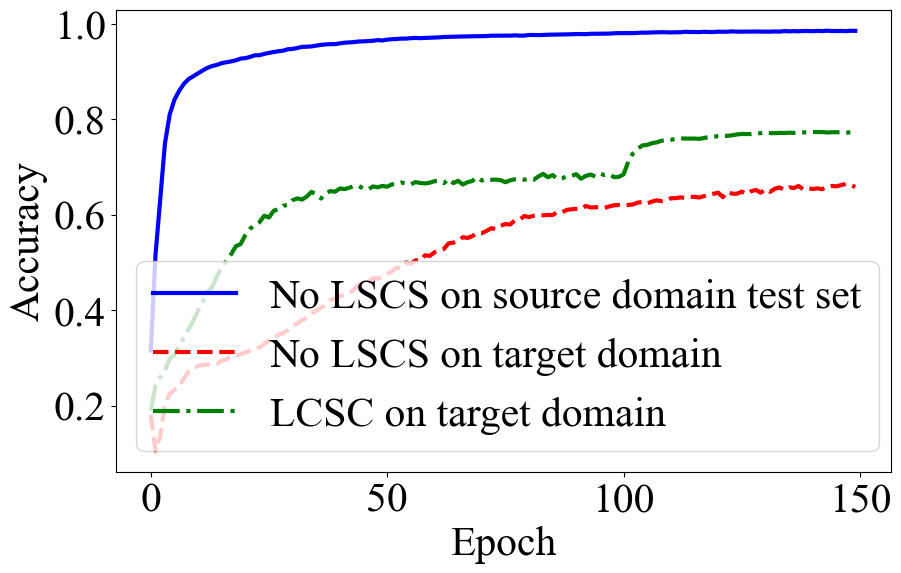

In [12]:
# plot Acc in train process
plt.rcParams['font.family'] = 'Times New Roman'
fontsize = 30
plt.figure(figsize=(10, 6))
plt.plot(Source_classifier_on_test_accs, label='No LSCS on source domain test set', color='blue', linestyle='-', linewidth=3)
plt.plot(Source_classifier_on_target_accs, label='No LSCS on target domain', color='red', linestyle='--', linewidth=3)
plt.plot(Deneralization_classifier_on_target_accs, label='LCSC on target domain', color='green', linestyle='-.', linewidth=3)
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.legend(prop={"family": "Times New Roman","size":fontsize})